# GHD

## Imports

In [69]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')

from skimage.transform import resize
from skimage.util.shape import view_as_windows
from skimage.feature import graycomatrix, graycoprops

from numba import jit, njit, prange

import cv2

from joblib import Parallel, delayed
import time



## Functions

In [11]:
def rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def disp(img, title='', s=8, vmin=None, vmax=None):
    plt.figure(figsize=(s,s))
    plt.axis('off')
    if vmin is not None and vmax is not None:
        plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

def uint8ify(img):
    img -= img.min()
    img /= img.max()
    img *= 255
    return np.uint8(img)

def overlay(a,b):
    # a and b should be float images and between 0-1

    mask = a >= 0.5 # generate boolean mask of everywhere a > 0.5 
    ab = np.zeros_like(a) # generate an output container for the blended image 

    # now do the blending 
    ab[~mask] = (2*a*b)[~mask] # 2ab everywhere a<0.5
    ab[mask] = (1-2*(1-a)*(1-b))[mask] # else this
    
    return ab

def before_after(img_a, img_b, name='', vmin=None, vmax=None, effect_name='Processed'):
    fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(10,4))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title(f'{name} Original')
    axs[1].set_title(f'{name} {effect_name}')
    if vmin is not None and vmax is not None:
        axs[0].imshow(img_a, cmap='gray', vmin=vmin, vmax=vmax)
        axs[1].imshow(img_b, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        axs[0].imshow(img_a, cmap='gray')
        axs[1].imshow(img_b, cmap='gray')
    plt.show()

## Load Images

In [13]:
def downsample(img, factor=2):
    return resize(img, (img.shape[0]//factor, img.shape[1]//factor), anti_aliasing=True)

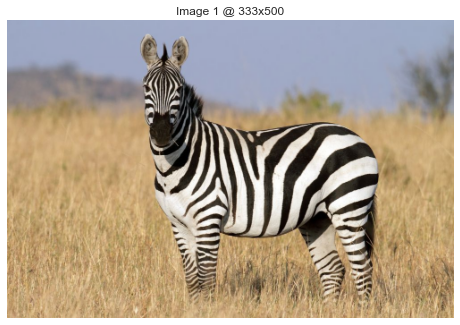

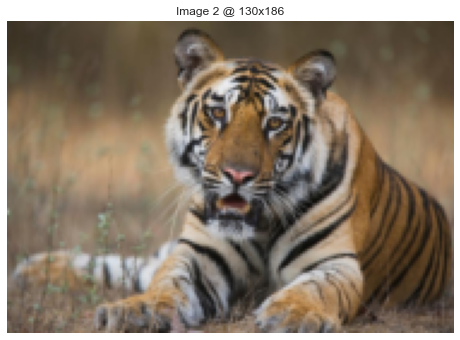

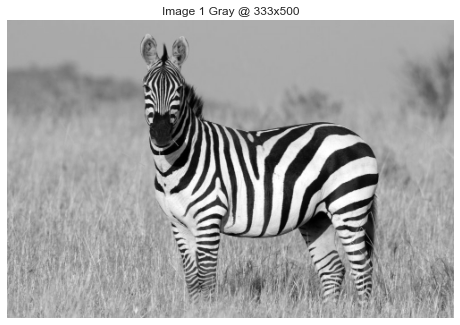

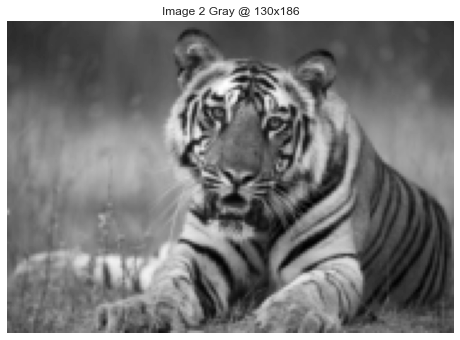

In [213]:
img1 = (downsample(rgb(cv2.imread('data\img1.jpg')), factor=2)*255).astype(np.uint8)
img1_gray = gray(img1)
img2 = (downsample(rgb(cv2.imread('data\img2.jpg')), factor=5)*255).astype(np.uint8)
img2_gray = gray(img2)

disp(img1, f'Image 1 @ {img1.shape[0]}x{img1.shape[1]}')
disp(img2, f'Image 2 @ {img2.shape[0]}x{img2.shape[1]}')

disp(img1_gray, f'Image 1 Gray @ {img1_gray.shape[0]}x{img1_gray.shape[1]}')
disp(img2_gray, f'Image 2 Gray @ {img2_gray.shape[0]}x{img2_gray.shape[1]}')

## GLCM Features

### get patches

In [59]:
def get_patches(img, patch_size=9, step_size=1, grayscale_levels=100):
    # reduce the number of levels in the image
    img = (img / 255 * grayscale_levels).astype(np.uint8)
    patches = view_as_windows(img, (patch_size, patch_size), step=step_size)
    return patches

def show_random_patches(patches, title=''):
    fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(8,8))
    fig.suptitle(title)
    for i in range(3):
        for j in range(3):
            axs[i,j].axis('off')
            axs[i,j].imshow(patches[np.random.randint(patches.shape[0]), np.random.randint(patches.shape[1])], cmap='gray')
    plt.show()

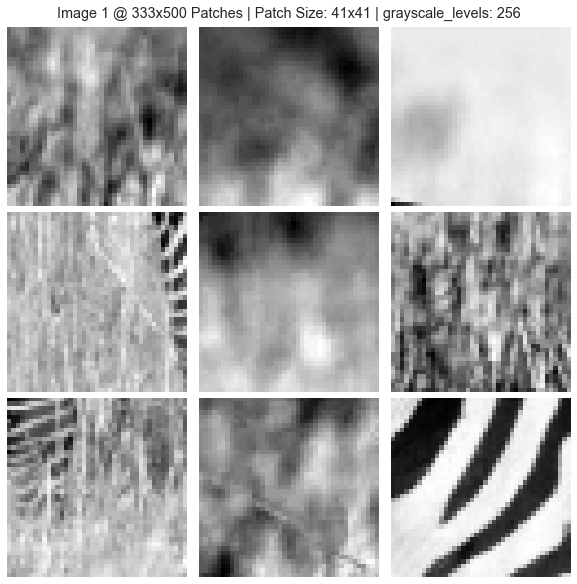

In [156]:
np.random.seed(2)
patches = get_patches(img1_gray, patch_size=41, step_size=1, grayscale_levels=256)
show_random_patches(patches, title=f"Image 1 @ {img1_gray.shape[0]}x{img1_gray.shape[1]} Patches | Patch Size: 41x41 | grayscale_levels: 256")

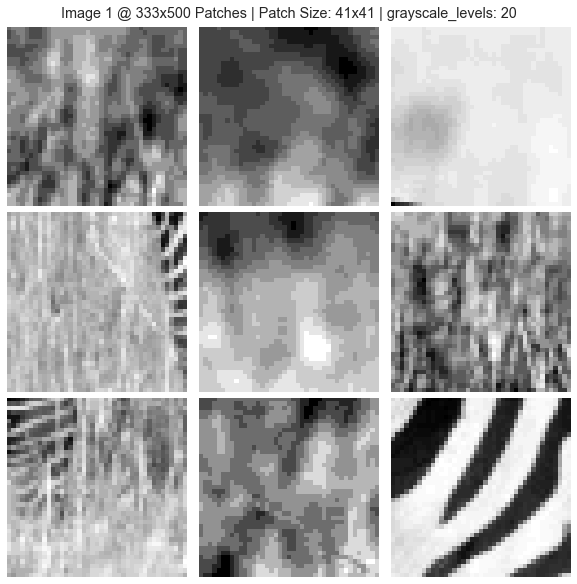

In [162]:
np.random.seed(2)
patches = get_patches(img1_gray, patch_size=41, step_size=1, grayscale_levels=50)
show_random_patches(patches, title=f"Image 1 @ {img1_gray.shape[0]}x{img1_gray.shape[1]} Patches | Patch Size: 41x41 | grayscale_levels: 20")

In [163]:
np.random.seed(0)

### GLCM Feature Extraction

In [148]:
def get_glcm_features(patches, levels=256, n_features=4):
    # GLCM features
    features = np.zeros((patches.shape[0], patches.shape[1], n_features))

    # Loop over patches
    start_time = time.time()
    for i in range(patches.shape[0]):
        time_elapsed = time.time() - start_time
        predicted_time = time_elapsed / (i+1) * patches.shape[0] - time_elapsed
        print(f'Processing row {i+1}/{patches.shape[0]} | Time Elapsed: {time_elapsed:.2f} secs | Time remaining: {predicted_time:.2f} secs', end='\r')
        for j in range(patches.shape[1]):
            glcm = graycomatrix(patches[i,j].copy(), [1], [0], levels=levels, symmetric=True, normed=True)

            features[i,j,0] = graycoprops(glcm, 'dissimilarity')[0, 0]
            if n_features == 1:
                continue
            
            features[i,j,1] = graycoprops(glcm, 'correlation')[0, 0]
            if n_features == 2:
                continue

            features[i,j,2] = graycoprops(glcm, 'contrast')[0, 0]
            if n_features == 3:
                continue

            features[i,j,3] = graycoprops(glcm, 'homogeneity')[0, 0]
            if n_features == 4:
                continue

            features[i,j,4] = graycoprops(glcm, 'ASM')[0, 0]
            if n_features == 5:
                continue

            features[i,j,5] = graycoprops(glcm, 'energy')[0, 0]
            if n_features > 6:
                raise ValueError('Too many features requested')
    return features

@jit
def get_glcm_features_numba(patches, levels=256, n_features=4):
    # GLCM features
    features = np.zeros((patches.shape[0], patches.shape[1], n_features))

    # Loop over patches
    for i in range(patches.shape[0]):
        if i % 10 == 0:
            print(f'Processing row {i+1}/{patches.shape[0]}')
        for j in range(patches.shape[1]):
            glcm = graycomatrix(patches[i,j].copy(), [1], [0], levels=levels, symmetric=True, normed=True)

            features[i,j,0] = graycoprops(glcm, 'dissimilarity')[0, 0]
            if n_features == 1:
                continue
            
            features[i,j,1] = graycoprops(glcm, 'correlation')[0, 0]
            if n_features == 2:
                continue

            features[i,j,2] = graycoprops(glcm, 'contrast')[0, 0]
            if n_features == 3:
                continue

            features[i,j,3] = graycoprops(glcm, 'homogeneity')[0, 0]
            if n_features == 4:
                continue

            features[i,j,4] = graycoprops(glcm, 'ASM')[0, 0]
            if n_features == 5:
                continue

            features[i,j,5] = graycoprops(glcm, 'energy')[0, 0]
            if n_features > 6:
                raise ValueError('Too many features requested')
    return features

@jit(parallel=True)
def get_glcm_features_numba_parallel(patches, levels=256, n_features=4):
    # GLCM features
    features = np.zeros((patches.shape[0], patches.shape[1], n_features))

    # Loop over patches
    for i in prange(patches.shape[0]): # Note the prange for the outer loop
        for j in range(patches.shape[1]):
            glcm = graycomatrix(patches[i,j].copy(), [1], [0], levels=levels, symmetric=True, normed=True)

            features[i,j,0] = graycoprops(glcm.copy(), 'dissimilarity')[0, 0]
            if n_features == 1:
                continue
            
            features[i,j,1] = graycoprops(glcm.copy(), 'correlation')[0, 0]
            if n_features == 2:
                continue

            features[i,j,2] = graycoprops(glcm.copy(), 'contrast')[0, 0]
            if n_features == 3:
                continue

            features[i,j,3] = graycoprops(glcm.copy(), 'homogeneity')[0, 0]
            if n_features == 4:
                continue

            features[i,j,4] = graycoprops(glcm.copy(), 'ASM')[0, 0]
            if n_features == 5:
                continue

            features[i,j,5] = graycoprops(glcm.copy(), 'energy')[0, 0]
            if n_features > 6:
                raise ValueError('Too many features requested')
    return features

In [173]:
def get_glcm_features_parallel(patches, levels=256, n_features=4):
    # GLCM features
    full_features = np.zeros((patches.shape[0], patches.shape[1], n_features))

    def extract_features(patch):
        glcm = graycomatrix(patch.copy(), [1], [0], levels=levels, symmetric=True, normed=True)
        features = np.zeros(n_features)
        features[0] = graycoprops(glcm, 'dissimilarity')[0, 0]
        if n_features == 1:
            return features

        features[1] = graycoprops(glcm, 'correlation')[0, 0]
        if n_features == 2:
            return features

        features[2] = graycoprops(glcm, 'contrast')[0, 0]
        if n_features == 3:
            return features

        features[3] = graycoprops(glcm, 'homogeneity')[0, 0]
        if n_features == 4:
            return features

        features[4] = graycoprops(glcm, 'ASM')[0, 0]
        if n_features == 5:
            return features

        features[5] = graycoprops(glcm, 'energy')[0, 0]
        if n_features > 6:
            raise ValueError('Too many features requested')
        return features

    # Loop over patches in parallel
    nprocs = 10
    result = []
    result.extend(Parallel(n_jobs=nprocs)(delayed(extract_features)(patches[i,j]) for i in range(patches.shape[0]) for j in range(patches.shape[1])))
    result = np.array(result)
    full_features = result.reshape(patches.shape[0], patches.shape[1], n_features)

    return full_features

### Speed Improvements

In [191]:
%%time
# One patch per pixel
levels = 100
patches = get_patches(img1_gray, patch_size=41, step_size=1, grayscale_levels=levels)
features = get_glcm_features(patches, levels=levels, n_features=5)
features.shape

KeyboardInterrupt: 

In [174]:
%%time
# One patch per pixel
levels = 50
patches = get_patches(img1_gray, patch_size=41, step_size=1, grayscale_levels=levels)
features = get_glcm_features_parallel(patches, levels=levels, n_features=5)
features.shape

CPU times: total: 18 s
Wall time: 27.9 s


(293, 460, 5)

In [ ]:
# %%time
# # One patch per pixel
# levels = 2
# patches = get_patches(img1_gray, patch_size=9, step_size=1, grayscale_levels=levels)
# features = get_glcm_features_numba(patches, levels=levels, n_features=3)
# features.shape

In [ ]:
# %%time
# # One patch per pixel
# levels = 2
# patches = get_patches(img1_gray, patch_size=9, step_size=1, grayscale_levels=levels)
# features = get_glcm_features_numba_parallel(patches, levels=levels, n_features=3)
# features.shape

### Clustering using K-Means

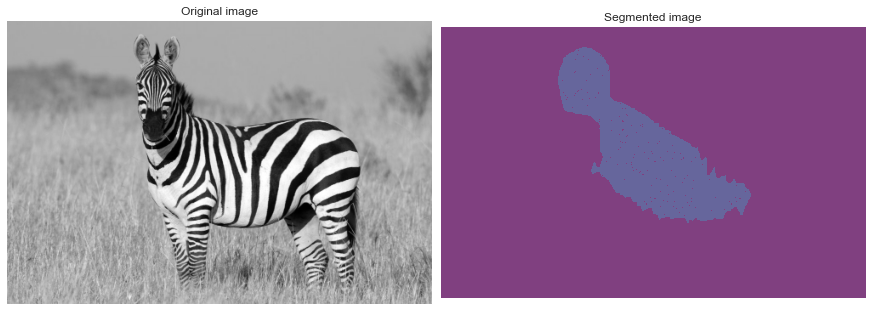

In [195]:
from sklearn.cluster import KMeans
from matplotlib import colors


kmeans = KMeans(n_clusters=3, random_state=2).fit(features.reshape(-1, features.shape[-1]))
labels = kmeans.labels_.reshape(features.shape[:2])

# Colormap
# make a color map of fixed colors
cmap = colors.ListedColormap([[10/255, 10/255, 10/255], [128/255, 64/255, 128/255], [102/255, 102/255, 156/255]])
bounds=[0,1,2,3]
norm = colors.BoundaryNorm(bounds, cmap.N)

# plot labels
fig, ax = plt.subplots(1, 2, figsize=(12, 10), constrained_layout=True)
ax[0].imshow(img1_gray, cmap='gray')
ax[0].set_title('Original image')
ax[0].set_axis_off()

ax[1].imshow(labels, cmap=cmap, norm=norm)
ax[1].set_title('Segmented image')
ax[1].set_axis_off()
plt.show()


In [208]:
def segment_image_glcm(img, levels=50, patch_size=41, n_features=5, random_state=2, n_clusters=2, debug=True):
    # One patch per pixel
    patches = get_patches(img, patch_size=patch_size, step_size=1, grayscale_levels=levels)
    features = get_glcm_features_parallel(patches, levels=levels, n_features=n_features)

    # Cluster features
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(features.reshape(-1, features.shape[-1]))
    labels = kmeans.labels_.reshape(features.shape[:2])

    # Make a color map of fixed colors
    if n_clusters == 3:
        cmap = colors.ListedColormap([[10/255, 10/255, 10/255], [128/255, 64/255, 128/255], [102/255, 102/255, 156/255]])
        bounds=[0,1,2,3]
    elif n_clusters == 2:
        cmap = colors.ListedColormap([[128/255, 64/255, 128/255], [102/255, 102/255, 156/255]])
        bounds=[0,1,2]

    norm = colors.BoundaryNorm(bounds, cmap.N)

    # plot labels
    if debug:
        fig, ax = plt.subplots(1, 2, figsize=(12, 10), constrained_layout=True)
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title('Gray image')
        ax[0].set_axis_off()

        ax[1].imshow(labels, cmap=cmap, norm=norm)
        ax[1].set_title('Segmented image')
        ax[1].set_axis_off()
        plt.show()

### Results

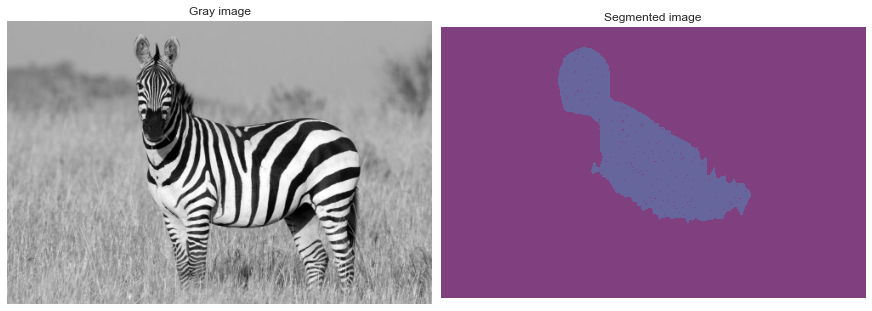

In [197]:
segment_image_glcm(img1_gray, levels=50, patch_size=41, n_features=5, random_state=2, debug=True)

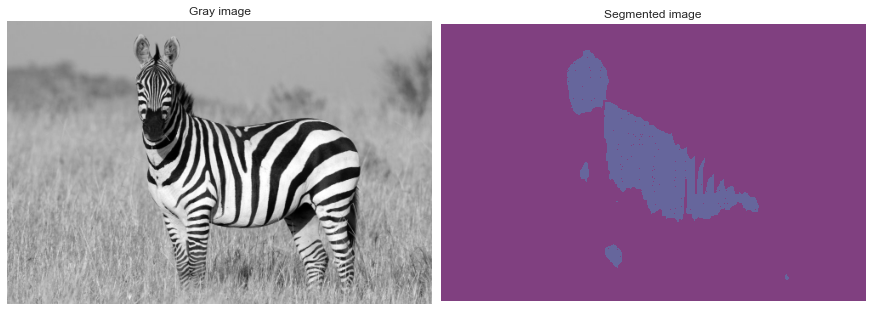

In [209]:
segment_image_glcm(img1_gray, levels=30, patch_size=21, n_features=6, random_state=2, debug=True)


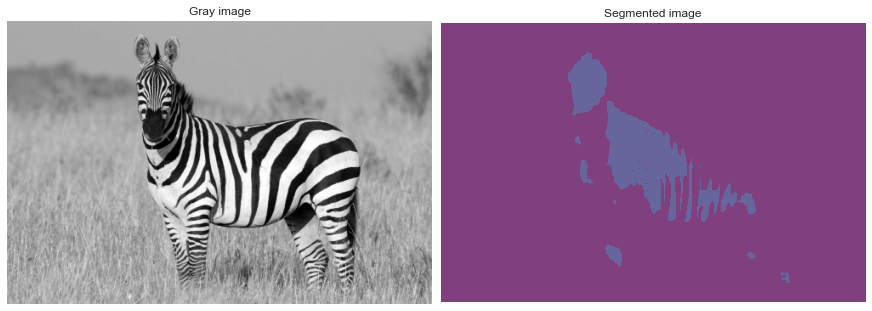

In [210]:
segment_image_glcm(img1_gray, levels=40, patch_size=15, n_features=3, random_state=2, debug=True)


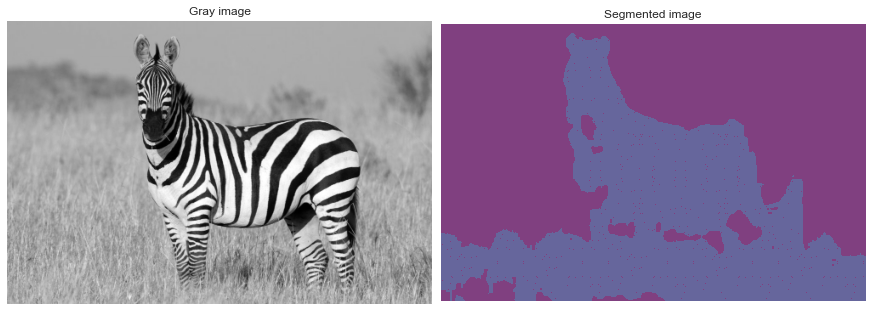

In [203]:
segment_image_glcm(img1_gray, levels=80, patch_size=21, n_features=2, random_state=2, debug=True)


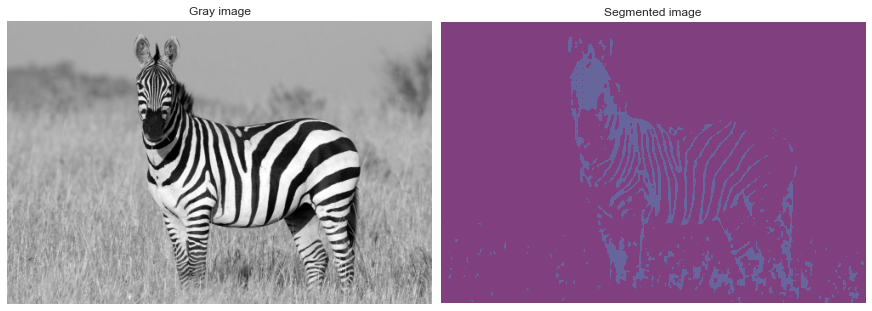

In [202]:
segment_image_glcm(img1_gray, levels=20, patch_size=5, n_features=2, random_state=2, debug=True)


In [ ]:
segment_image_glcm(img1_gray, levels=50, patch_size=71, n_features=2, random_state=2, debug=True)


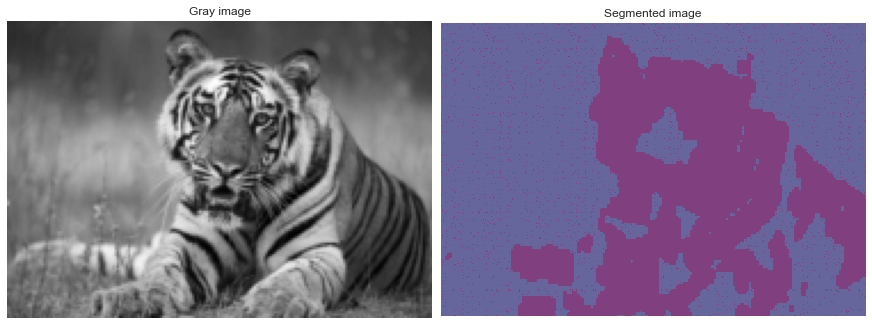

In [219]:
segment_image_glcm(img2_gray, levels=255, patch_size=7, n_features=1, random_state=3, debug=True)


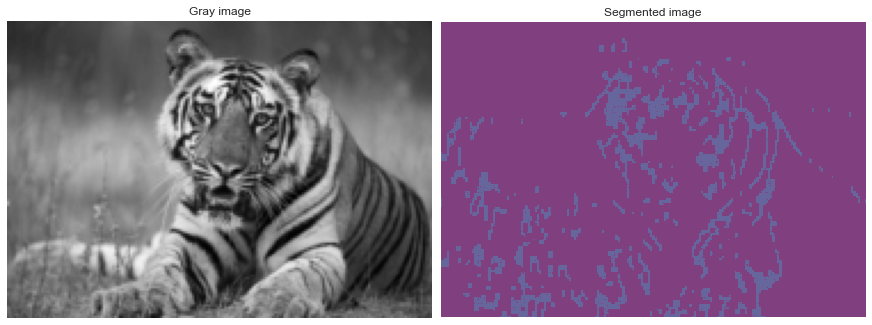

In [220]:
segment_image_glcm(img2_gray, levels=2, patch_size=3, n_features=2, random_state=2, debug=True)


## Gabor Filters Feature extraction

sigma σ – Standard Deviation – Property of our bell curve. Smaller values emphasize values closer to the center

theta θ – Direction – Identifies direction of our sine wave

lambda λ – Wavelength – Distance between peaks in our sine wave

gamma γ – Ellipticity – Determines how elliptic our 2D bell curve is

psi φ – Offset – Defines the phase offset of our sine wave


In [263]:
def gabor_filter_bank(scales=5, angles=8, ksize=35, lambd=10, gamma=0.5, psi=0):
    filters = np.zeros((scales, angles, ksize, ksize))
    # ksize = 35  # The local area to evaluate
    # lambd = 10.0
    # gamma = 0.5
    # psi = 0  # Offset value - lower generates cleaner results
    i = 0
    j = 0
    for i, sigma in enumerate(np.linspace(ksize/30, ksize/10, scales)):
        for j, theta in enumerate(np.arange(0, np.pi, np.pi / angles)):  # Theta is the orientation for edge detection
            kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
            kern /= 1.0 * kern.sum()  # Brightness normalization
            filters[i, j, :, :] = kern
    return filters

def show_gabor_filters(scales=5, angles=8, ksize=35, lambd=10, gamma=0.5, psi=0):
    filters = gabor_filter_bank(scales, angles, ksize, lambd, gamma, psi)
    fig, ax = plt.subplots(scales, angles, figsize=(10, 6), constrained_layout=True)
    for i in range(scales):
        for j in range(angles):
            ax[i, j].imshow(filters[i, j, :, :], cmap='gray')
            ax[i, j].set_axis_off()
    plt.show()


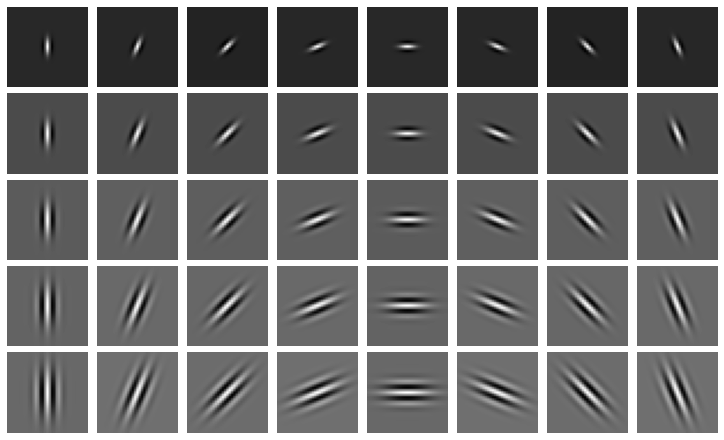

In [264]:
show_gabor_filters(scales=5, angles=8, ksize=35, lambd=5, gamma=0.5, psi=0)

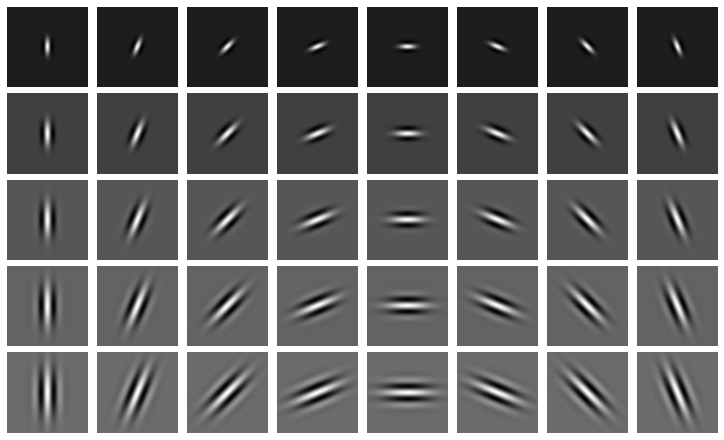

In [267]:
show_gabor_filters(scales=5, angles=8, ksize=151, lambd=25, gamma=0.5, psi=0)

In [238]:
def gabor_feature_extraction(img, filters):
    features = np.zeros((filters.shape[0], filters.shape[1], img.shape[0], img.shape[1]))
    for i in range(filters.shape[0]):
        for j in range(filters.shape[1]):
            features[i, j, :, :] = cv2.filter2D(img, cv2.CV_8UC3, filters[i, j, :, :])
    return features
    

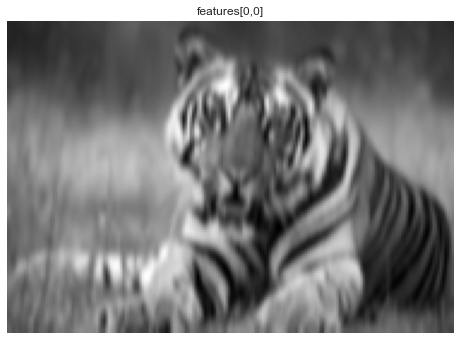

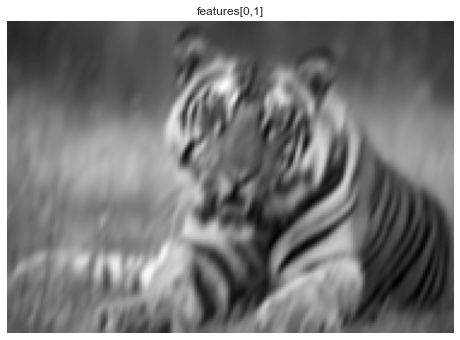

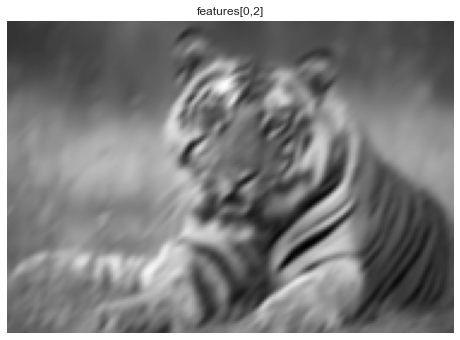

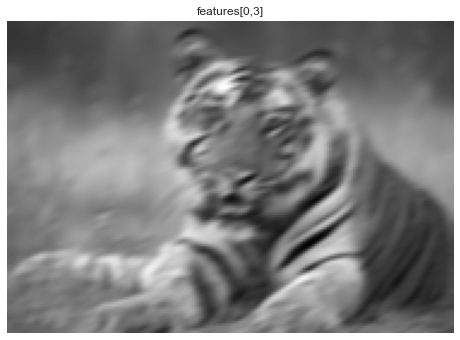

In [241]:
features = gabor_feature_extraction(img2_gray, gabor_filter_bank(scales=5, angles=8, ksize=35, lambd=5, gamma=0.5, psi=0))
disp(features[0,0], "features[0,0]")
disp(features[0,1], "features[0,1]")
disp(features[0,2], "features[0,2]")
disp(features[0,3], "features[0,3]")


In [257]:
def segment_image_gabor(img, scales=5, angles=8, ksize=35, lambd=5, gamma=0.5, psi=0, n_clusters=2, random_state=2, debug=True):
    # One patch per pixel
    features = gabor_feature_extraction(img, gabor_filter_bank(scales, angles, ksize, lambd, gamma, psi))

    # Cluster features
    print(features.shape)
    X = features.transpose(2, 3, 0, 1) # (scales,angles,height,width) -> (height,width,scales,angles)
    X = X.reshape(-1, scales*angles) # (height,width,scales,angles) -> (height*width,scales*angles)
    print(X.shape)
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(X)
    labels = kmeans.labels_.reshape(img.shape[:2])

    # Make a color map of fixed colors
    if n_clusters == 3:
        cmap = colors.ListedColormap([[10/255, 10/255, 10/255], [128/255, 64/255, 128/255], [102/255, 102/255, 156/255]])
        bounds=[0,1,2,3]
    elif n_clusters == 2:
        cmap = colors.ListedColormap([[128/255, 64/255, 128/255], [102/255, 102/255, 156/255]])
        bounds=[0,1,2]

    norm = colors.BoundaryNorm(bounds, cmap.N)

    # plot labels
    if debug:
        fig, ax = plt.subplots(1, 2, figsize=(12, 10), constrained_layout=True)
        ax[0].imshow(img, cmap='gray')
        ax[0].set_title('Gray image')
        ax[0].set_axis_off()

        ax[1].imshow(labels, cmap=cmap, norm=norm)
        ax[1].set_title('Segmented image')
        ax[1].set_axis_off()
        plt.show()

(5, 8, 333, 500)
(166500, 40)


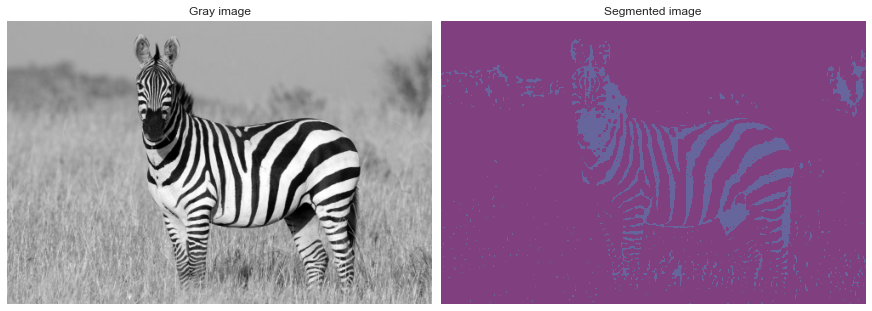

In [258]:
segment_image_gabor(img1_gray, scales=5, angles=8, ksize=35, lambd=5, gamma=0.5, psi=0, n_clusters=2, random_state=2, debug=True)


(5, 8, 333, 500)
(166500, 40)


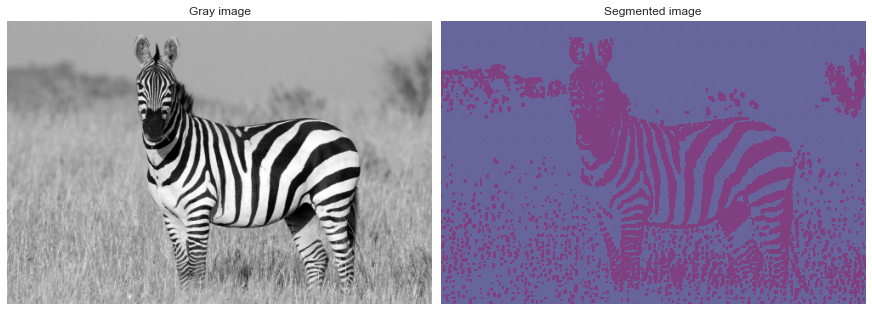

In [260]:
segment_image_gabor(img1_gray, scales=5, angles=8, ksize=51, lambd=5, gamma=0.5, psi=0, n_clusters=2, random_state=2, debug=True)


(5, 8, 333, 500)
(166500, 40)


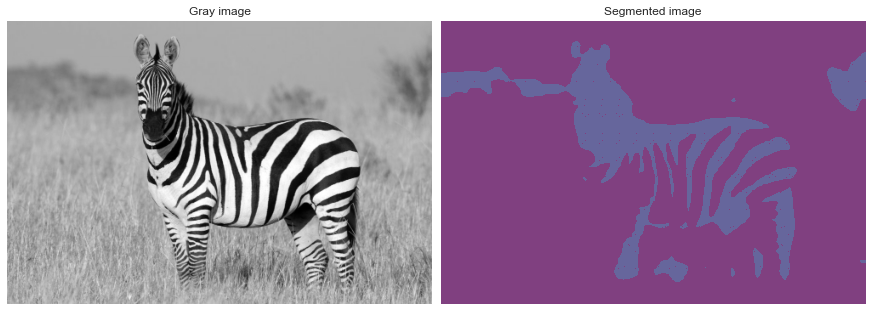

In [271]:
segment_image_gabor(img1_gray, scales=5, angles=8, ksize=71, lambd=31, gamma=0.5, psi=0, n_clusters=2, random_state=2, debug=True)


(5, 8, 130, 186)
(24180, 40)


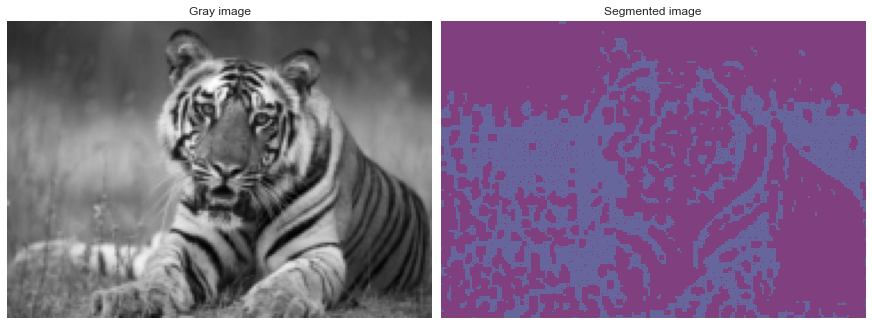

In [259]:
segment_image_gabor(img2_gray, scales=5, angles=8, ksize=35, lambd=5, gamma=0.5, psi=0, n_clusters=2, random_state=2, debug=True)


(6, 8, 130, 186)
(24180, 48)


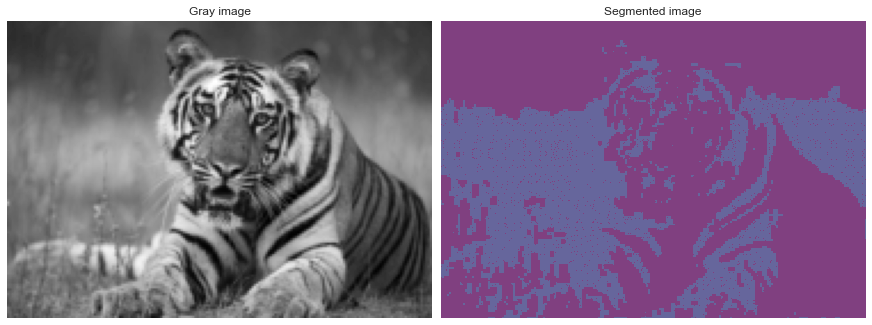

In [274]:
segment_image_gabor(img2_gray, scales=6, angles=8, ksize=5, lambd=1, gamma=0.5, psi=0, n_clusters=2, random_state=2, debug=True)
